# Chapter 4 AP

Jack Krebsbach | Statistics for Data Science | Nov 2023


## # 13
Using the ```Weekly``` data set.

In [199]:
from ISLP import confusion_table
import numpy as np
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn import linear_model
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler

##### Load Data
We load the Weekly data set from ISLP.

In [200]:
Weekly = load_data('Weekly')
Weekly.shape

(1089, 9)

(b) Use the full data set to perform a logistic regression with
Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

The only variable that appears to be statistically significant is the ```Lag2``` variable with a p value of 0.03.

In [201]:
design = MS([ 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume'])
X = design.fit_transform(Weekly)
y = Weekly.Direction == "Up"
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

From the confusion matrix, the logistic model is having a hard time predicting when the market will go down. It has an easier time prediciting if the market will go up.

In [202]:
## Get the probabilities
probs = results.predict() 
probs [:10]

array([0.60862494, 0.60103144, 0.58756995, 0.48164156, 0.61690129,
       0.56841902, 0.57860971, 0.51519724, 0.57151998, 0.55542873])

In [203]:
labels = np.array(['Down']*1089) 
labels[probs>0.5] = "Up"

In [204]:
confusion_table(labels, Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).
)

The fraction of predictions that are correct for the held out data set is 0.538 (see confusion matrix below).

In [205]:
train = (Weekly.Year < 2009) & (Weekly.Year > 1989) 
Weekly_train = Weekly.loc[train]
Weekly_test = Weekly.loc[~train] 
print(f'Testing Shape: {Weekly_test.shape}')
print(f'Training Shape: {Weekly_train.shape}')
Weekly_test

Testing Shape: (104, 9)
Training Shape: (985, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
985,2009,6.760,-1.698,0.926,0.418,-2.251,3.793110,-4.448,Down
986,2009,-4.448,6.760,-1.698,0.926,0.418,5.043904,-4.518,Down
987,2009,-4.518,-4.448,6.760,-1.698,0.926,5.948758,-2.137,Down
988,2009,-2.137,-4.518,-4.448,6.760,-1.698,6.129763,-0.730,Down
989,2009,-0.730,-2.137,-4.518,-4.448,6.760,5.602004,5.173,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [206]:
X_train, X_test = X.loc[train], X.loc[~train] 
y_train, y_test = y.loc[train], y.loc[~train]
design = MS(['Lag2'])
X = design.fit_transform(X_train)
glm_train = sm.GLM(y_train, X_train , family=sm.families.Binomial()) 
results = glm_train.fit()

probs = results.predict(exog=X_test)

In [207]:
D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [208]:
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up' 
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,31,44
Up,12,17


In [209]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.46153846153846156, 0.5384615384615384)

(e) Repeat (d) using LDA.

Again the fraction of the test set that LDA can predict correctly is still 0.538.


In [210]:
lda = LDA(store_covariance=True)
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [211]:
lda.means_

array([[ 1.        ,  0.28944444, -0.03568254,  0.17080045,  0.15925624,
         0.21409297,  1.26696554],
       [ 1.        , -0.00921324,  0.26036581,  0.08404044,  0.09220956,
         0.04548897,  1.15652914]])

In [212]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [213]:
lda.priors_

array([0.44771574, 0.55228426])

In [214]:
lda.scalings_

array([[ 0.        ],
       [-0.27269007],
       [ 0.19316443],
       [-0.06828419],
       [-0.13646358],
       [-0.16316423],
       [-0.39859766]])

In [215]:
# Create confusion matrix
labels = lda.predict(X_test)
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,31,44
Up,12,17


In [216]:
# Get the accuracy on the test set
np.mean(labels == L_test), np.mean(labels != L_test)

(0.46153846153846156, 0.5384615384615384)

(f) Repeat (d) using QDA.

Here we see that the more flexible model, QDA, can produce better results on the test set. It achieves ~58% accuracy on the test set.

In [217]:
qda = QDA(store_covariance=True) 
qda.fit(X_train, L_train)

/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(store_covariance=True)

In [218]:
qda_pred = qda.predict(X_test) 
confusion_table(qda_pred, L_test)

/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:954: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


Truth,Down,Up
Predicted,,
Down,43,61
Up,0,0


In [219]:
# Get the accuracy on the test set
np.mean(qda_pred == L_test), np.mean(qda_pred != L_test)

(0.41346153846153844, 0.5865384615384616)

(g) Repeat (d) using KNN with K = 1.

KNN performs worse with an accuracy on the test set of ~51.9%.

In [220]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,21,32
Up,22,29


In [221]:
# Get the accuracy on the test set
np.mean(knn1_pred == L_test), np.mean(knn1_pred != L_test)

(0.4807692307692308, 0.5192307692307693)

(h) Repeat (d) using naive Bayes.

Naive Bayes performs about the same as LDA, achieving an accuracy of ~54.8% on the test set. 

In [222]:
# Instantiate object
NB = GaussianNB()
NB.fit(X_train, L_train)
# Extract confusion matrix
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,42,56
Up,1,5


In [223]:
# Get the accuracy on the test set
np.mean(nb_labels == L_test), np.mean(nb_labels != L_test)

(0.4519230769230769, 0.5480769230769231)

(i) Which of these methods appears to provide the best results on this data?

On this data set it appears that Quadratic Discriminant Analysis performs the best.

(j) Experiment with different combinations of predictors, includ- ing possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.


- KNN the optimal number of nearest neighbors is 4. 
-  QDA with a interaction term between Lag1 and Lag2 achieved an accuracy on the test set of ~44%
- QDA with a quadratic term (Lag1^2) achieved an accuracy of 49%.

Note that adding these interaction terms and the quadratic terms added linearity to the feature set, so it is not advisable to keep them

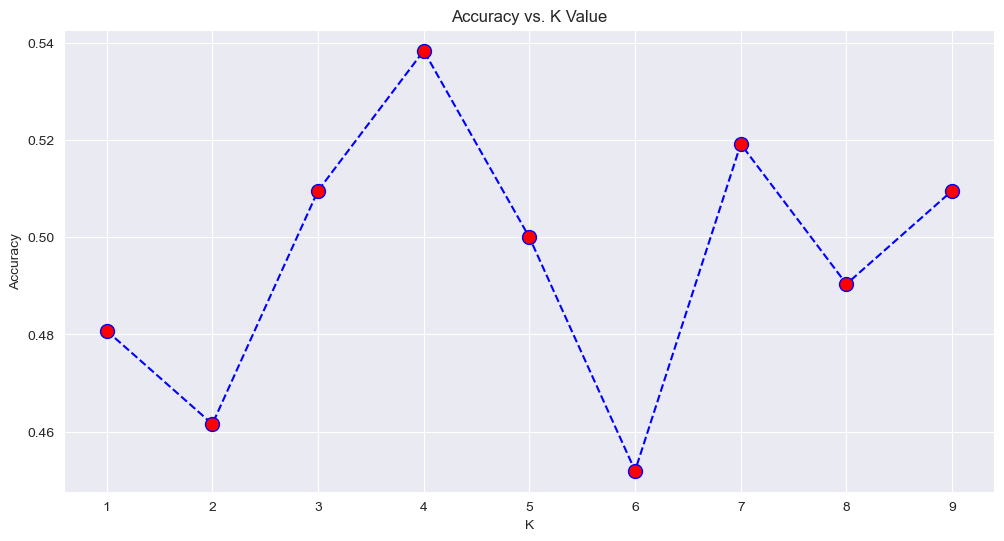

The optimal number of neighbors is 4
With accuracy 0.5384615384615384


In [224]:
# Try different number of nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Range of k to try
k_range = range(1, 10)
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, L_train)
    pred = knn.predict(X_test)
    accuracy = accuracy_score(L_test, pred)
    accuracies.append(accuracy)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(k_range, accuracies, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

# Finding the optimal k value
optimal_k = k_range[accuracies.index(max(accuracies))]
print(f"The optimal number of neighbors is {optimal_k}")
print(f"With accuracy {accuracies[accuracies.index(max(accuracies))]}")


In [225]:
# Look at the columns
X_train.columns

Index(['intercept', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume'], dtype='object')

In [226]:
# Copy the data to make interaction terms
X_train_new = X_train.copy()
X_test_new = X_test.copy()

In [227]:
# Try quadratic term in L!
X_train_new.reset_index(inplace=True)
X_test_new.reset_index(inplace=True)

X_train_new['L1_L2'] = X_train_new.Lag1 * X_train_new.Lag2
X_test_new['L1_L2'] = X_test_new.Lag1*  X_train_new.Lag2

X_test_new.drop('Lag1', axis=1)

qda = QDA(store_covariance=True) 

qda.fit(X_train_new, L_train)
pred1 = qda.predict(X_test_new)


print(np.mean(pred1 != L_test))

confusion_table(pred1, L_test)


0.4423076923076923


/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Truth,Down,Up
Predicted,,
Down,3,6
Up,40,55


In [228]:
# Copy the data to check interaction terms
X_train_new = X_train.copy()
X_test_new = X_test.copy()

In [229]:
# Try quadratic term in L!
X_train_new.reset_index(inplace=True)
X_test_new.reset_index(inplace=True)

X_train_new['L1^2'] = X_train_new.Lag1 * X_train_new.Lag1
X_test_new['L1^2'] = X_test_new.Lag1*  X_train_new.Lag1

X_test_new.drop('Lag1', axis=1)

qda = QDA(store_covariance=True) 

qda.fit(X_train_new, L_train)
pred1 = qda.predict(X_test_new)

np.mean(pred1 != L_test)
confusion_table(pred1, L_test)

/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Truth,Down,Up
Predicted,,
Down,1,9
Up,42,52


## 2 

#### Load the data

In [230]:
from sklearn import datasets
iris = datasets.load_iris()

The features are stored in iris['data'] and the labels are in iris['target'].

### Afterwards, standardize the features and apply 2D PCA to the standardized data. Plot the first two principal components of the data, color coded by the true labels.


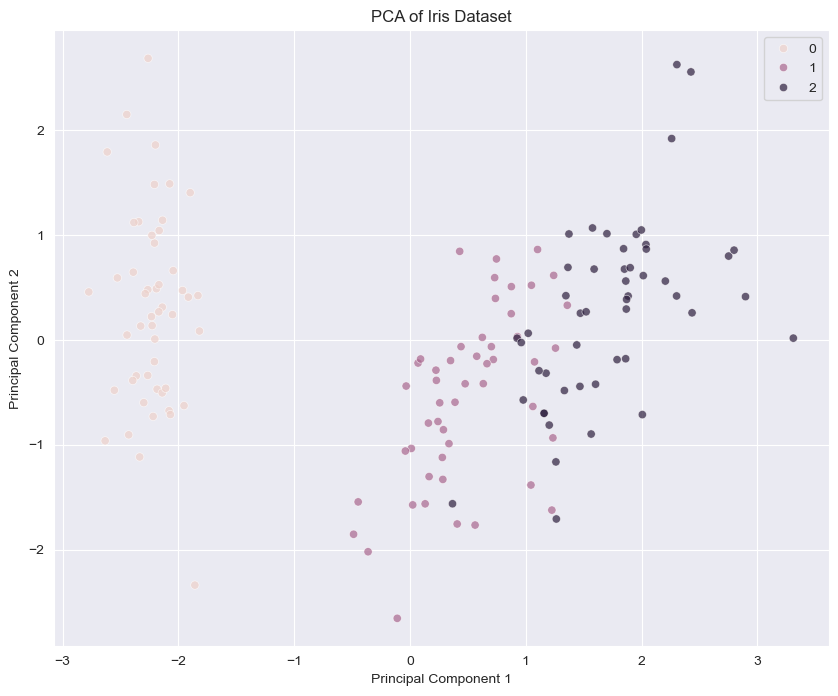

In [231]:
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principal_data = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=principal_data, x='PC1', y='PC2', hue=y, alpha=0.7)
plt.title('PCA of Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### (2) Now focus on the two classes, 'versicolor' and 'virginica', and fit a binary logistic regression model. What is the training error? Plot also the decision boundary.

The training error is ~88%


In [232]:
class_names  = iris.target_names
print(f'Class Names: {class_names}')

Class Names: ['setosa' 'versicolor' 'virginica']


In [233]:
# Filter the classes we want
X = principal_data[(iris.target == 2) | (iris.target == 1)]
y = iris.target[(iris.target == 2) | (iris.target == 1)]

# We predict virginica as True or 1
y = y == 2

#Fit the model 
LRmodel = linear_model.LogisticRegression(penalty=None).fit(X, y)
predictions = LRmodel.predict(X)
print(f'Training Accuracy: {np.mean(predictions == y)}')
LRprobs = LRmodel.predict_proba(X)

Training Accuracy: 0.88


/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


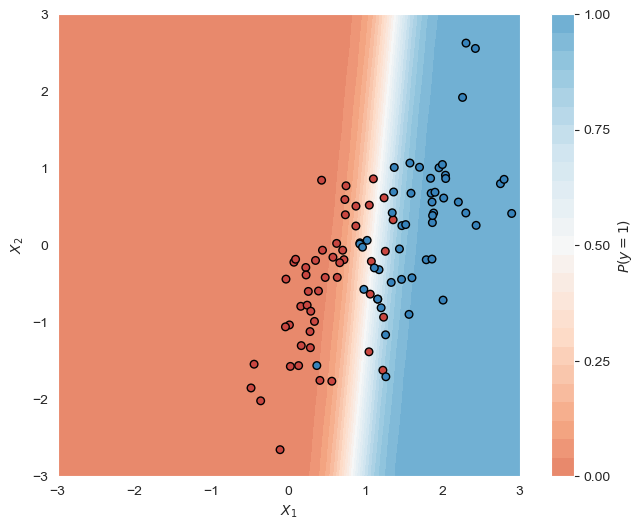

In [234]:
# Create a mesh grid
xx, yy = np.mgrid[-3.5:3.5:.1, -3.5:3.5:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
LRprobs = LRmodel.predict_proba(grid)[:, 1].reshape(xx.shape)

# Now, plot the probability grid as a contour map and additionally show the test set samples on top of it:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, LRprobs, 30, cmap="RdBu", vmin=-0.5, vmax=1.5)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X.PC1, X.PC2, c=y, s=30,
           cmap="RdBu", vmin=-0.25, vmax=1.25,
           edgecolor="black", linewidth=1)

ax.set(aspect="equal",
       xlim=(-3, 3), ylim=(-3, 3),
       xlabel="$X_1$", ylabel="$X_2$");

### (3) For the above two iris classes, fit two more models: LDA and QDA. What are their training error rates? Plot their decision boundaries together with the binary logistic regression model. Which model do you think is the most appropriate for these two classes? 


Both LDA and QDA achieve training error rates of ~88%. Based off of the plot, we do not need the flexibility of QDA  or LR. In addition they appear to have similar co-variance. Therefore, LDA is most appropriate for these two classes.

In [235]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
lda = LinearDiscriminantAnalysis(store_covariance=True)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

In [236]:
X

,PC1,PC2
50,1.101781,0.862972
51,0.731337,0.594615
52,1.240979,0.616298
53,0.407483,-1.754404
54,1.075475,-0.208421
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


In [237]:
# Fit the linear discriminant analysis
lda.fit(X, y)
prediction_lda = lda.predict(X)
print(f'Training Accuracy LDA: {np.mean(prediction_lda == y)}')

# Fit the Quadratic Discriminant analysis
qda.fit(X, y)
prediction_qda = lda.predict(X)
print(f'Training Accuracy QDA: {np.mean(prediction_qda == y)}')

Training Accuracy LDA: 0.88
Training Accuracy QDA: 0.88


/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


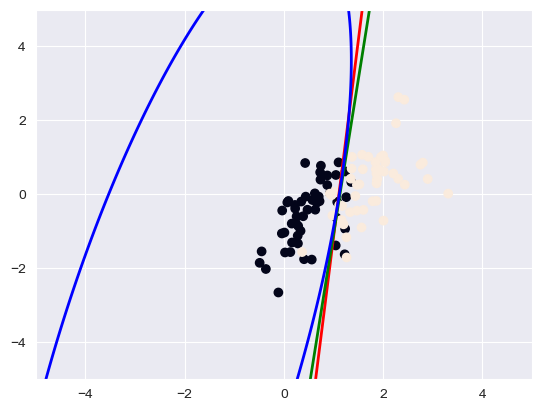

In [238]:
# Plot the data and decision boundary
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
LRprobs = LRmodel.predict_proba(grid)[:, 1].reshape(xx.shape)

# Get Predictions for Linear Discriminant Analysis
Z_lda = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_lda = Z_lda[:, 1].reshape(xx.shape)

# Get predictions for Quadratic Discriminant Analysis
Z_qda = qda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_qda = Z_qda[:, 1].reshape(xx.shape)


# Plot Data
plt.scatter(x=X.PC1, y=X.PC2, c=y) # plot the data

# Plot Decision Boundaries
plt.contour(xx, yy, LRprobs, [0.5], linewidths=2.0, colors="red")  # logistic
plt.contour(xx, yy, Z_lda, [0.5], linewidths=2.0, colors="green")  # LDA
plt.contour(xx, yy, Z_qda, [0.5], linewidths=2.0, colors="blue")   # QDA


### (4) Apply the one-versus-rest multiclass logistic regression classifier to all three classes of the iris data (using the two dimensional principal components obtained above). Display the confusion matrix and comment on it. What is the overall training error?

 The classifier does a good job, achieving a training error of ~92%. It had the hardest time classifying the second and third class, which makes sense as visually we can see them clumped together in the PCA plot above.

In [239]:
# Using multi_class = 'ovr' fits a one-versus-rest for each class 
LRmodelOVR = linear_model.LogisticRegression(penalty=None, multi_class='ovr').fit(principal_data, iris.target)
predictions = LRmodelOVR.predict(principal_data)
print(np.mean(predictions == iris.target))
confusion_table(predictions, iris.target)

0.92


Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,42,4
2,0,8,46


### (5)  Repeat (4) with the multinomial logistic regression classifier instead. How does it compare with the one-versus-rest extension?

We get the exact same accuracy. However, in the first class an observation that was previously misclassified was corrected and the opposite occurred in the third class.

In [240]:
LRmodelMultinomial = linear_model.LogisticRegression(penalty=None, multi_class='multinomial').fit(principal_data, iris.target)
predictions = LRmodelMultinomial.predict(principal_data)
print(np.mean(predictions == iris.target))
confusion_table(predictions, iris.target)

0.92


Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,43,5
2,0,7,45


In [241]:
LRmodelMultinomial.classes_

array([0, 1, 2])

### (6) Repeat (4) with each of the LDA and QDA classifiers. How do they compare with logistic regression in terms of training error? Which one will generalize the best to test data (when they become available)?

In terms of the training error, LDA seems to perform the best at ~93%. But QDA, LDA, and logistic regression all perform about the same. QDA and LDA produce test accuracies of ~92%.

Logistic regression is a good choice as we can see in the PCA plot that the classes are linearly separable. However, even though LDA performed better on the training set, we see that each class generally does not of the same co-variance. LR does not assume any of the distributions of classes, therefore I would expect it to perform best on the test set.

In [242]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

In [243]:
# Fit the linear discriminant analysis
lda.fit(principal_data, iris.target)
lda_predictions = lda.predict(principal_data)
print(np.mean(lda_predictions == iris.target))
confusion_table(lda_predictions, iris.target)

0.9333333333333333


Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,45,5
2,0,5,45


In [244]:
# Fit the Quadratic Discriminant analysis
qda.fit(principal_data, iris.target)
qda_predictions = qda.predict(principal_data)
print(np.mean(qda_predictions == iris.target))
confusion_table(qda_predictions, iris.target)

0.92


Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,43,5
2,0,7,45
